Setup helper functions.

In [5]:
import os
import rasterio
from rasterio.windows import Window
import pandas as pd


def convert_spatial_to_pixel(
    x_spatial, y_spatial, im_width_px=27569, im_width_m=292.48, im_height_px=28814
):
    """
    Convert spatial coordinates to pixel coordinates.

    Parameters:
    - x_spatial, y_spatial: Coordinates in the spatial reference system, assumed to be in meters.
    - resolution_cm_per_pixel: Ground resolution in cm/pixel. Default is 1 cm/pixel.

    Returns:
    - (x_pixel, y_pixel): Tuple of pixel coordinates.
    """
    conversion_factor = im_width_px / im_width_m

    x_pixel = x_spatial * conversion_factor
    y_pixel = y_spatial * conversion_factor
    y_pixel = im_height_px - y_pixel

    return x_pixel, y_pixel


def chunk_image(image_path, image_chunk_path, chunk_size=576, overlap=32):

    os.makedirs(image_chunk_path, exist_ok=True)

    with rasterio.open(image_path) as src:
        for j in range(0, src.height, chunk_size - overlap):
            for i in range(0, src.width, chunk_size - overlap):
                window = Window(i, j, chunk_size, chunk_size)
                transform = src.window_transform(window)

                out_image = src.read(window=window)
                out_meta = src.meta.copy()

                # Update metadata with new dimensions, transform, and compression
                out_meta.update(
                    {
                        "driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": transform,
                        "compress": "lzw",
                    }
                )

                out_path = os.path.join(image_chunk_path, f"{i}_{j}.tif")
                with rasterio.open(out_path, "w", **out_meta) as dest:
                    dest.write(out_image)

                # print(f"Saved {out_path}")


def chunk_labels(
    labels_path, label_chunk_path, chunk_size=576, overlap=32, image_shape=None
):
    labels = pd.read_csv(labels_path)
    labels[["X_pixel", "Y_pixel"]] = labels.apply(
        lambda row: convert_spatial_to_pixel(row["X"], row["Y"]),
        axis=1,
        result_type="expand",
    )

    os.makedirs(label_chunk_path, exist_ok=True)

    # Assuming labels dataframe has columns ['X', 'Y', 'label']
    for j in range(0, image_shape[0], chunk_size - overlap):
        for i in range(0, image_shape[1], chunk_size - overlap):
            # Filter labels within the current chunk
            chunk_labels = labels[
                (labels["X_pixel"] >= i)
                & (labels["X_pixel"] < i + chunk_size)
                & (labels["Y_pixel"] >= j)
                & (labels["Y_pixel"] < j + chunk_size)
            ].copy()

            # Adjust labels' X, Y to the new chunk's coordinate system
            chunk_labels["X_pixel"] -= i
            chunk_labels["Y_pixel"] -= j

            # Save chunk labels to CSV
            chunk_labels.to_csv(
                os.path.join(label_chunk_path, f"{i}_{j}.csv"), index=False
            )
            # print(f"Saved {i}_{j}.csv")

Set up source and save paths.

In [6]:
# Specify paths
image_path = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\seabirds_rgb.tif"
labels_path = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\labels_birds_full.csv"
image_dir = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\image-chunks"
label_dir = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\label-chunks"

Check image shape.

In [7]:
# Get image shape
with rasterio.open(image_path) as src:
    image_shape = (src.height, src.width)
print(image_shape)

(28814, 27569)


Chunk labels.

In [ ]:
chunk_labels(
    labels_path,
    label_dir,
    chunk_size=576,
    overlap=32,
    image_shape=image_shape,
)

Then, chunk images.

In [ ]:
chunk_image(image_path, image_dir, chunk_size=576, overlap=32)

Optionally verify success of `m`->`pixel` transformation.

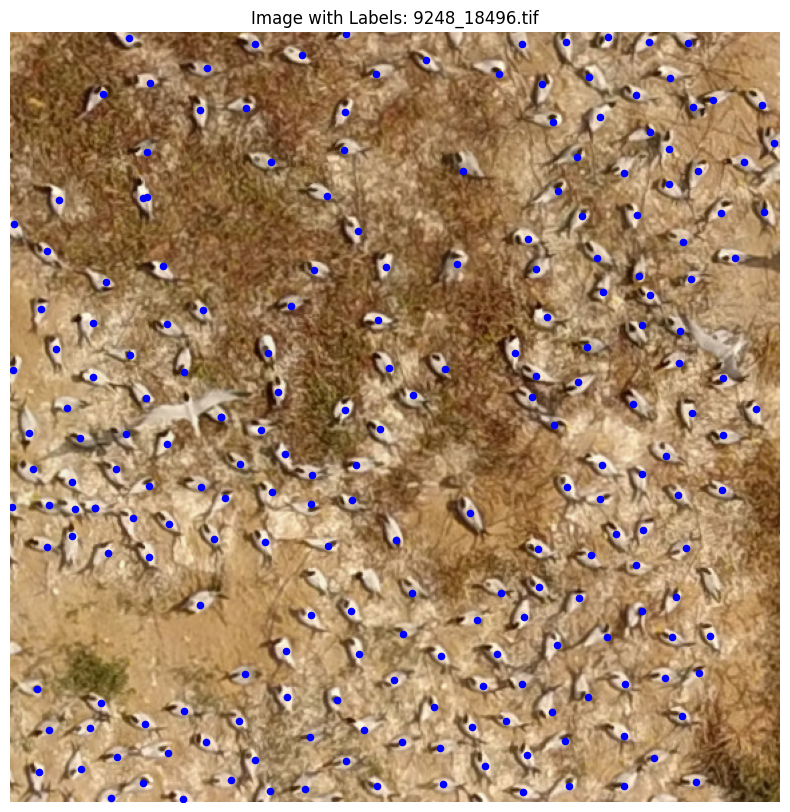

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import random

# List all image and label files
image_files = [
    os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".tif")
]
label_files = [
    os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".csv")
]

# Filter out label files that are small
valid_label_files = [f for f in label_files if os.path.getsize(f) > 100]

# Select a random label file that is not empty
selected_label_file = random.choice(valid_label_files)
# Find the corresponding image file
selected_image_file = os.path.join(
    image_dir, os.path.basename(selected_label_file).replace(".csv", ".tif")
)

# Load the image
image = Image.open(selected_image_file)

# Load the labels
labels = pd.read_csv(selected_label_file)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)

# Overlay the label points
plt.scatter(labels["X_pixel"], labels["Y_pixel"], color="blue", s=20)

plt.title(f"Image with Labels: {os.path.basename(selected_image_file)}")
plt.axis("off")
plt.show()

Convert .tif to .jpg for use downstream.

In [12]:
from PIL import Image
import os

# Source and destination directories
src_dir = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\image-chunks"
dst_dir = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\image-chunks-jpg"

# Create the destination directory if it doesn't exist
os.makedirs(dst_dir, exist_ok=True)

# Convert each .tif to .jpg
for filename in os.listdir(src_dir):
    if filename.endswith(".tif"):
        img_path = os.path.join(src_dir, filename)
        img = Image.open(img_path)
        # Remove the file extension and add .jpg
        jpg_filename = os.path.splitext(filename)[0] + ".jpg"
        jpg_path = os.path.join(dst_dir, jpg_filename)
        img.save(jpg_path, "JPEG")

print("Conversion complete.")

Conversion complete.


Convert annotations.

In [2]:
import json
import pandas as pd
import os

# Paths
birds_pnt_path = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\image-chunks-jpg\birds.pnt"
csv_dir = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\label-chunks"
output_pnt_path = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\image-chunks-jpg\birds_annotated.pnt"

# Load the existing birds.pnt data
with open(birds_pnt_path, "r") as file:
    birds_data = json.load(file)

# Initialize 'points' if not in birds_data
if "points" not in birds_data:
    birds_data["points"] = {}

# For each CSV file, read the annotations and update birds_data
for csv_file in os.listdir(csv_dir):
    if csv_file.endswith(".csv"):
        csv_path = os.path.join(csv_dir, csv_file)
        df = pd.read_csv(csv_path)

        # Extract the base filename without extension to use as key in birds_data
        base_filename = csv_file.replace(".csv", ".jpg")

        # Check if there's an entry for this image and initialize if not
        if base_filename not in birds_data["points"]:
            birds_data["points"][base_filename] = {}

        # Initialize 'bird' as empty list if not present
        if "bird" not in birds_data["points"][base_filename]:
            birds_data["points"][base_filename]["bird"] = []

        # For each row in the CSV, add a bird annotation
        for _, row in df.iterrows():
            # Only add annotation if coordinates are not missing
            if not pd.isnull(row["X_pixel"]) and not pd.isnull(row["Y_pixel"]):
                bird_annotation = {"x": row["X_pixel"], "y": row["Y_pixel"]}
                birds_data["points"][base_filename]["bird"].append(bird_annotation)

# Save the updated data to birds_annotated.pnt
with open(output_pnt_path, "w") as file:
    json.dump(birds_data, file, indent=4)

print("Conversion complete.")

Conversion complete.


Create not-empty dir (for CVAT).

In [3]:
import os
import shutil
import pandas as pd

# Paths
csv_dir = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\label-chunks"
src_dir = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\image-chunks-jpg"
dst_dir = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\label-image-chunks-jpg"

os.makedirs(dst_dir, exist_ok=True)

for csv_file in os.listdir(csv_dir):
    if csv_file.endswith(".csv"):
        csv_path = os.path.join(csv_dir, csv_file)
        df = pd.read_csv(csv_path)
        if len(df) > 1:
            filename_without_extension, _ = os.path.splitext(csv_file)
            src_jpg_path = os.path.join(src_dir, filename_without_extension + ".jpg")
            dst_jpg_path = os.path.join(dst_dir, filename_without_extension + ".jpg")

            shutil.copy(src_jpg_path, dst_jpg_path)

Create new JSON-like structure with some bounding boxes included.

In [ ]:
src_pnt_path = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\image-chunks-jpg\birds_annotated.pnt"
src_pnt_path = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\image-chunks-jpg\birds_annotated.pnt"

# Load the existing birds.pnt data
with open(src_pnt_path, "r") as file:
    birds_data = json.load(file)

# Initialize 'points' if not in birds_data
if "points" not in birds_data:
    birds_data["points"] = {}

# For each CSV file, read the annotations and update birds_data
for csv_file in os.listdir(csv_dir):
    if csv_file.endswith(".csv"):
        csv_path = os.path.join(csv_dir, csv_file)
        df = pd.read_csv(csv_path)

Convert Datamuro format to new JSON.

In [2]:
import json

datamuro = r"C:\Users\tomsg\Work\open-source\DotDotGoose\datasets\aerial-seabirds-west-africa\birds-datamuro\annotations\default.json"

with open(datamuro, "r") as file:
    data = json.load(file)

# Convert to the specified JSON format
result = {}
for item in data["items"]:
    image_name = f'{item["id"]}.jpg'
    boxes = []
    for annotation in item["annotations"]:
        # bbox format in the input: [x, y, width, height]
        # Convert to [[x1, y1], [x2, y2]] format
        bbox = annotation["bbox"]
        box = [[bbox[0], bbox[1]], [bbox[0] + bbox[2], bbox[1] + bbox[3]]]
        boxes.append(box)
    result[image_name] = boxes

# Define the file path
file_path = "converted_data.json"

# Save the JSON data to the file
with open(file_path, "w") as json_file:
    json.dump(result, json_file)

file_path

'converted_data.json'